# Analyse the results of the RNAseq experiments
- Differences between FBC106 and FBC should be shown
- Which genes are up/down regulated? --> Volcano plot (show especially genes involved in lipid metabolism and PIK3C)
- Are there any cluster of genes? Do they belong to any GO-term / Pathways? Create lists of Up/Down regulated genes for further analysis

## Include libraries

In [3]:
import numpy as np
import xml.etree.ElementTree as ET
import os

from matplotlib import pylab as plt
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Functions and definitions

In [4]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

#Colormap suggested by Julia
c = mcolors.ColorConverter().to_rgb
Julia_cmap = make_colormap(
    [c('#f6e1d1'), c('#941852')])

In [9]:
def read_lipid_genes():
    '''
    This functions extracts all fatty acid metabolism genes (and corresponding pathways) from KeGG pathways (manually downloaded)
    return: dict[Pathway] = ['Gene1','Gene2']
    '''
    
    #read all xml files
    files_xml = [i for i in  os.listdir('../data/Fatty_Acid_Metabolism/') if i.endswith('.xml')]
    
    
    genes_per_pathway = {}
    for file in files_xml:
        tree = ET.parse('../data/Fatty_Acid_Metabolism/' + file)
        root = tree.getroot()
        
        pathway = root.get('title')
        genes_per_pathway[pathway] = set()
        
        for entry in root.findall('entry'):
            if entry.get('type') == 'gene':
                
                data = entry.find('graphics')
                
                #print(data)
                found_genes = [x.replace(' ','') for x in data.get('name').strip().split(',')]
                
                genes_per_pathway[pathway] = genes_per_pathway[pathway].union(found_genes)
            

        
    return genes_per_pathway
    
    


In [10]:
selected_genes = ['Alox5',
                    'Pik3c2a',
                    'Pik3cb',
                    'Pik3r4',
                    'Pik3r5',
                    'Pik3r1',
                    'Pik3cg',
                    'Pik3ap1',
                    'Pten']

lipid_pathways = read_lipid_genes()

## Main part

### 1. Make heatmap using fpkm values

In [14]:
#Get only significant genes
significant_genes = []

#Read transcription data, extract all genes that are considered as significantly differentially expressed
fp = open('../data/RNAseq_Data/rnaseq_deseq_global_contrast_group_FBC206_vs_FBC_against_intercept_genes.tsv','r')
fp.readline()
for line in fp:
    tmp = line.strip().split('\t')

    if tmp[11] == "yes":
        significant_genes.append(tmp[0])
fp.close()

print('Number of significant genes: %d' %len(significant_genes))


#Extract actual sample names
fp = open('../data/RNAseq_Data/rnaseq_deseq_global_counts_vst_model.tsv')
groups = [x.replace('"','') for x in fp.readline().strip().split('\t')[6:]]
print(groups)



#Go through all rows (= genes), if gene is significant (see above), add it to the data vector
#add a blue/red color depending wheter the gene is protein coding (red) or not (blue)
data = []
gene_types = []
for line in fp:
    tmp = line.strip().split('\t')

    
    gene_id = tmp[0]
    gene_id = gene_id.replace('"','')

    gene_name = tmp[2]
    gene_name = gene_name.replace('"','')

    gene_type = tmp[3]
    gene_type = gene_type.replace('"','')
    
    if gene_type == 'protein_coding':
        gene_types.append('red')
    else:
        gene_types.append('blue')
    
    
    if gene_id in significant_genes:


        read_counts = [float(x) for x in tmp[6:]]

        data.append(read_counts)
fp.close()

Number of significant genes: 3709
['S_1_FBC_S63515', 'S_2_FBC_S63514', 'S_3_FBC_S63511', 'S_4_FBC206_S63510', 'S_5_FBC206_S63513', 'S_6_FBC206_S63512']


In [14]:
# Make the actual clustermap
##
sns.clustermap(data, cmap=Julia_cmap, z_score=0,
              col_colors=['#F8B301','#F8B301','#F8B301','#3AB9D1','#3AB9D1','#3AB9D1'],
               row_colors = gene_types,
              xticklabels=groups,yticklabels=[])
plt.savefig('../results/RNA_seq/Heatmap.pdf')
plt.close()

### 2. Analyse UP and DOWN regulated genes

In [25]:
# Make lists for significant up/down regulated genes, additionally to the 'significant' columns, also only include values with abs(FC) > 1 (foldchange)
##

#Get only significant genes
UP_regulated_gn = [] #Gene Name
UP_regulated_gi = [] #Gene ID

DOWN_regulated_gn = []
DOWN_regulated_gi = []


fp = open('../data/RNAseq_Data/rnaseq_deseq_global_contrast_group_FBC206_vs_FBC_against_intercept_genes.tsv','r')
fp.readline()
for line in fp:
    tmp = line.strip().split('\t')

    if tmp[11] == "yes":
        if abs(float(tmp[7])) > 1:

            if float(tmp[7]) > 1:
                UP_regulated_gn.append(tmp[2])
                UP_regulated_gi.append(tmp[0])
            else:
                DOWN_regulated_gn.append(tmp[2])
                DOWN_regulated_gi.append(tmp[0])

        
fp.close()
print('Number of significant genes: %d' %len(significant_genes))
print('Number of UP regulated: %d' %len(UP_regulated_gn))
print('Number of DOWN regulated: %d' %len(DOWN_regulated_gn))


fp_out = open('../results/RNA_seq/Up_RegulatedFC_1.csv','w')
for name,ID in zip(UP_regulated_gn,UP_regulated_gi):
    fp_out.write(ID+','+name+'\n')
fp_out.close()
    
    
fp_out = open('../results/RNA_seq/Down_RegulatedFC_1.csv','w')
for name,ID in zip(DOWN_regulated_gn,DOWN_regulated_gi):
    fp_out.write(ID+','+name+'\n')
fp_out.close()

Number of significant genes: 3709
Number of UP regulated: 161
Number of DOWN regulated: 10


### 3. Show where particular interesting genes are

In [16]:
# manually seleted interesting genes(see above)
interesting_genes = list(selected_genes)
colormap  = cm.get_cmap('tab20')

#dictionaries for saving values
pathway_colors = {}
legend_colors = {'Selected':'#40004b'}
gene_to_pathway  = {}
parsed_gene_per_Group = {}

#give each interesting genes a category, i.e., selection and color
for gene in interesting_genes:
    pathway_colors[gene] = '#40004b'
    gene_to_pathway[gene] = 'Selection'
    parsed_gene_per_Group['Selection'] = []

#additionally add all fatty acid genes that have been found
for val,txt in enumerate(lipid_pathways.keys()):
    parsed_gene_per_Group[txt] = []

    legend_colors[txt] = colormap(val)
    for gene in lipid_pathways[txt]:
        pathway_colors[gene] = colormap(val)
        gene_to_pathway[gene] = txt
    interesting_genes.extend(lipid_pathways[txt])

In [283]:
fp = open('../data/rnaseq_deseq_global_contrast_group_FBC206_vs_FBC_against_intercept_genes.tsv','r')
#fp = open('../data/rnaseq_deseq_global_lrt_wo_group.tsv')
print(fp.readline().split('\t'))




# Same as above but with adding more information to the vulcano plot
##

#those are needed to additionally plot points after the vulcano plot was created (else interesting points are invisible below all other points)
special_on_top_x = []
special_on_top_y = []
special_node_color = []
special_label = []

# Threshold for pvalue (after MH orrection)
##
threshold = 0.00001

log2FoldChanges = []
pvals = []
labels = []
node_color = []
for line in fp:
    tmp = line.strip().split('\t')
    
    label = tmp[2]
    
    labels.append(label)
    
    # if FC = NA, fc = 0
    ##
    if tmp[7] != 'NA':
        fc = float(tmp[7])
        
    else:
        fc = 0
    
    # if pval = NA, pval = 0
    ##
    if tmp[9] != "NA":
        pval = float(tmp[9])
        #pval = float(tmp[9])
    else:
        pval = 0.0
        
    pvals.append(pval)
    log2FoldChanges.append(fc)
    
    #if the gene is within interesting genes
    if label not in interesting_genes:

    
        if pval < threshold and abs(fc) > 1:
            node_color.append('#e31a1c') #red
            print (label)
        elif pval < threshold and abs(fc) < 1:
            #node_color.append('#1f78b4') #blue
            node_color.append('grey') #grey
        elif pval > threshold and abs(fc) > 1:
            #node_color.append('#33a02c') #green
            node_color.append('grey') #grey
        else:
            node_color.append('grey')
    
    #if not ineresting than maybe it is part of a fatty acid pathway
    else:

        node_color.append(pathway_colors[label])
        
        
        special_on_top_x.append(fc)
        special_on_top_y.append(pval)
        special_node_color.append(pathway_colors[label])
        special_label.append(label)

        
        parsed_gene_per_Group[gene_to_pathway[label]].append(label)
    

MinusLog10pVals = [-np.log10(x) for x in pvals]

special_on_top_y = [-np.log10(x) for x in special_on_top_y]

['gene_id', 'gene_version', 'gene_name', 'gene_biotype', 'gene_source', 'location', 'baseMean', 'log2FoldChange', 'lfcSE', 'pvalue', 'padj', 'significant', 'rank_log2_fold_change', 'rank_base_mean', 'rank_padj', 'max_rank\n']
Cd28
Tns1
Rgl1
Rnasel
Ralgps2
Tnfsf18
Fcgr2b
Slamf1
Ifi206
Ifi213
Ifi208
Ifi203
Gm18445
Kmo
Tlr5
Gm38079
Pfkfb3
Mrc1
Fcna
Sema6d
Bmp2
Tox2
Mmp9
Slc12a5
Gpr34
Vsig4
Cxcr3
Gm6377
P2ry13
P2ry12
Pdgfc
Sema4a
Enpep
Bank1
Gm12354
Susd1
Csf3r
Marcksl1
Pla2g2d
Car6
Plekhg5
Tnfrsf25
Samd11
Asb10
Cd38
Pf4
Cxcl10
Hpse
Galnt9
Trpv4
Oasl1
Oas2
Hcar2
Ccl24
Nxpe5
Mrm2
Ppp1r9a
Met
Tmem176b
Tmem176a
Hrh1
Clec4n
Cd163
Cd4
Klra3
Rasgrp4
Hpn
Cd33
Rcn3
Fcgrt
Siglech
Mctp2
Gm15880
Ctsc
Trim30b
Trim30c
Lyve1
Chp2
Il4ra
Il21r
Ifitm1
Tspan32
Gm48786
Fabp7
Rhobtb1
Spic
Cd209a
Cd209e
Cd209d
Cd209b
Cd209c
Cd209f
Cd209g
F7
Gas6
Kbtbd11
Hpgd
Ddx60
Maf
Stab1
Ang
Fgf9
Gm49417
Ednrb
Mmp12
Kank2
Scn3b
Trim29
Fxyd2
Calml4
Slc9a9
Tlr9
Entpd3
Tcn2
Osm
Lif
Timd4
Asgr2
Mgl2
Clec10a
Ccl2
Ccl7
Ccl12
Ccl8

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log10


### 4. Make actual Volcano plot with interesting points

174
All genes: 55471
Number significant: 25251


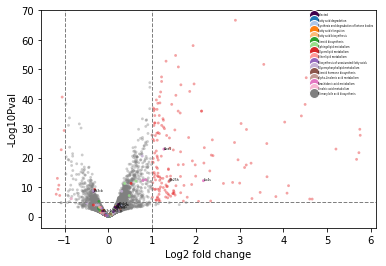

In [282]:
#create legend entries
legend_elements = []
for key in legend_colors.keys():
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=key,
                      markerfacecolor=legend_colors[key], markersize=10))


print(node_color.count('#e31a1c'))

print ('All genes: %d' %len(MinusLog10pVals))
print('Number significant: %d' %len([x for x in MinusLog10pVals if x > 5]))


plt.scatter(log2FoldChanges,MinusLog10pVals, alpha=0.4, c=node_color, s=8, lw=0)
plt.axvline(-1, ls='--', color='grey', lw=1)
plt.axvline(1, ls='--', color='grey', lw=1)
plt.axhline(5,ls='--',color='grey' , lw=1)
plt.xlabel('Log2 fold change')
plt.ylabel('-Log10Pval')


plt.scatter(special_on_top_x,special_on_top_y,c=special_node_color,alpha=0.75, s=8, lw=0)

for i, txt in enumerate(labels):
    if txt in interesting_genes:
        if (abs(log2FoldChanges[i]) > 1 and MinusLog10pVals[i]) > 5 or  txt in selected_genes:
            plt.annotate(txt, (log2FoldChanges[i], MinusLog10pVals[i]), size=3)


plt.legend(handles=legend_elements, loc='upper right',prop={'size': 2.5}, frameon=False)

     
     
plt.savefig('../results/RNA_seq/Volcano.pdf')




fp_out = open('../results/RNA_seq/Selected_Genes_Volcano.csv','w')
fp_out.write('GeneGroup,Gene_Name,NumberOfGenes\n')
#fp_out.write('Selected_Genes,'+';'.join(selected_genes)+'\n')
for key in parsed_gene_per_Group:
    fp_out.write(key+','+';'.join(parsed_gene_per_Group[key])+','+str(len(parsed_gene_per_Group[key]))+'\n')
fp_out.close()